# Learning Objective

# In this tutorial, you discovered how to build a face recognition system using eigenface, which is derived from principal component analysis (PCA).

# Specifically, you learned:

# 1. How to extract characteristic images from the image dataset using principal component analysis

# 2. How to use the set of characteristic images to create a weight vector for any seen or unseen images

# 3. How to use the weight vectors of different images to measure for their similarity, and apply this technique to face recognition

# 4. How to reconstruct original images using the obtained PCA?

# 5. How to generate a new random image from the characteristic images

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import zipfile
import os

In [ ]:
from google.colab import files
upload = files.upload()

Saving facesDF.zip to facesDF.zip


In [ ]:
## This deals with how to read a particular format
## of files from a zip file recursively
## Very useful piece of code although not directly
## related to PCA
## The below is to read every PGM file in the zip.
## PGM is a grayscale image file format. We extract
## each PGM file into a byte string through image.read()
## and convert it into a numpy array of bytes. Then we use
## OpenCV to decode the byte string into an array of pixels
## using cv2.imdecode(). The file format will be detected
## automatically by OpenCV. We save each picture into a Python
## dictionary faces for later use.

# Read face image from zip file on the fly
faces = {}

with zipfile.ZipFile("facesDF.zip") as facezip:
    for filename in facezip.namelist():
        if not filename.endswith(".pgm"):
            continue # not a face picture
        with facezip.open(filename) as image:
            # If we extracted files from zip, we can use cv2.imread(filename) instead
            # What does cv2.imdecode function do?? Check the official documentation
            # https://docs.opencv.org/3.4/d4/da8/group__imgcodecs.html#ga26a67788faa58ade337f8d28ba0eb19e
            # What is a buffer when reading files?
            # A buffer is a region of memory used to temporarily store data.
            faces[filename] = cv2.imdecode(np.frombuffer(image.read(), np.uint8),
                                           cv2.IMREAD_GRAYSCALE)


Showing sample faces


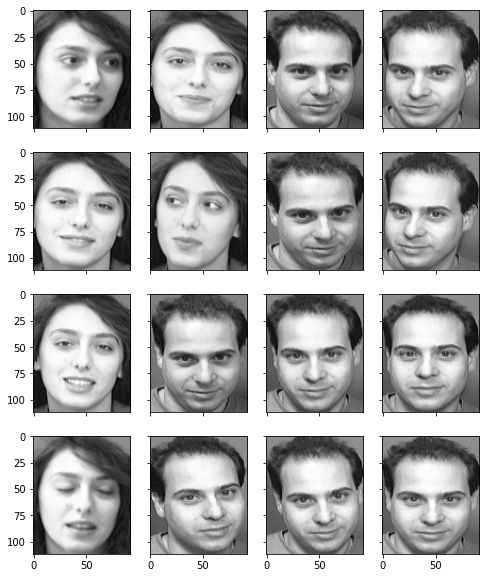

In [ ]:
# Show sample faces using matplotlib
## How to view images, what function do I use to view image?

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    ## what function to use to show image
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

In [ ]:
# Print some details
faceshape = list(faces.values())[0].shape
print("Face image shape:", faceshape)

## What is the dimension of the feature space?


classes = set(filename.split("/")[0] for filename in faces.keys())
print("Number of classes:", len(classes))
print("Number of images:", len(faces))

Face image shape: (112, 92)
Number of classes: 40
Number of images: 400


In [ ]:
# Take classes 1-39 for eigenfaces, keep entire class 40 and
# image 10 of class 39 as out-of-sample test
facematrix = []
facelabel = []
for key,val in faces.items():
    if key.startswith("s40/"):
        continue # this is our test set
    if key == "s39/10.pgm":
        continue # this is our test set
    facematrix.append(val.flatten())
    facelabel.append(key.split("/")[0])

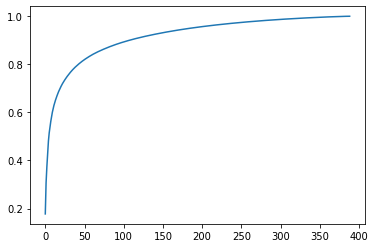

In [ ]:
# Create a NxM matrix with N images and M pixels per image
facematrix = np.array(facematrix)

# Apply PCA and take first K principal components as eigenfaces
pca = PCA().fit(facematrix)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

# We have seen this block of code once, where do we see it?
# In What Scenario?

Showing the eigenfaces


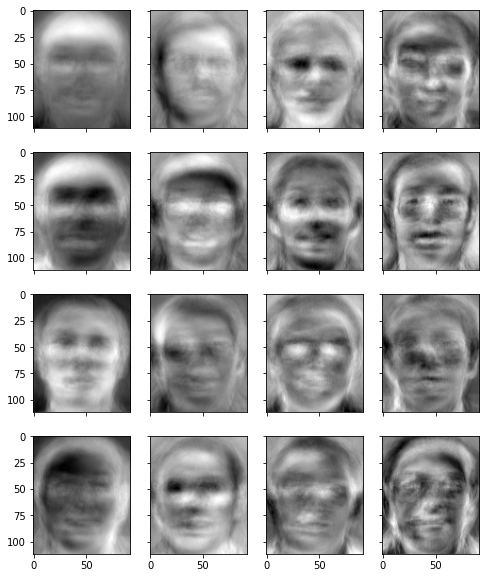

In [ ]:
n_components = 50

# How to get the eignfaces, the first 50 principle components
# ToDO:
eigenfaces = pca.components_[:n_components]

## In order to understand //, you can read the below post
## https://www.programiz.com/python-programming/operators
## to understand the meaning of all the operators in python

# Show the first 16 eigenfaces
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(eigenfaces[i].reshape(faceshape), cmap="gray")
print("Showing the eigenfaces")
plt.show()

# For any given face picture, we can project its mean-subtracted version onto the eigenface picture using vector dot-product. The result is how close this face picture is related to the eigenface. If the face picture is totally unrelated to the eigenface, we would expect its result is zero. For the K eigenfaces, we can find K dot-product for any given face picture. We can present the result as weights of this face picture with respect to the eigenfaces. The weight is usually presented as a vector.

#Conversely, if we have a weight vector, we can add up each eigenfaces subjected to the weight and reconstruct a new face. Let’s denote the eigenfaces as matrix F, which is a L×K matrix, and the weight vector w is a column vector. Then for any w, we can construct the picture of a face as
#$$Z= F\cdot w,$$

#which  is resulted as a column vector of length L. Because we are only using the top K principal component vectors, we should expect the resulting face picture is distorted but retained some facial characteristic.


#Since the eigenface matrix is constant for the dataset, a varying weight vector w means a varying face picture. Therefore we can expect the pictures of the same person would provide similar weight vectors, even if the pictures are not identical. As a result, we may make use of the distance between two weight vectors (such as the L2-norm) as a metric of how two pictures resemble.

Shape of the weight matrix: (50, 389)
Best match s39 with Euclidean distance 1559.997137


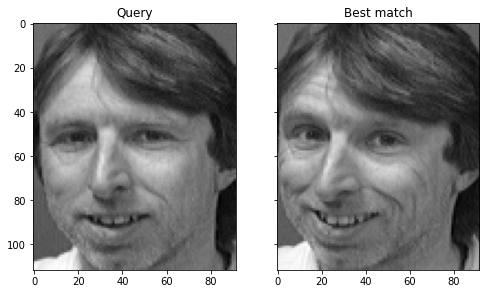

In [ ]:
# Generate weights as a KxN matrix where K is the number of eigenfaces
# and N the number of samples

# Since our goal is to build a face recognition system,
# we first calculate the weight vector for each input
# picture:

# This @ operator is just used for matrix multiplication.
# You can read the details here:
# https://alysivji.github.io/python-matrix-multiplication-operator.html

weights = eigenfaces @ (facematrix - pca.mean_).T
print("Shape of the weight matrix:", weights.shape)

# Test on out-of-sample image of existing class
query = faces["s39/10.pgm"].reshape(1,-1)
# Todo:
# How to find the weights for the query image?
query_weight = eigenfaces @ (query - pca.mean_).T

euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Best match s5 with Euclidean distance 2690.209330


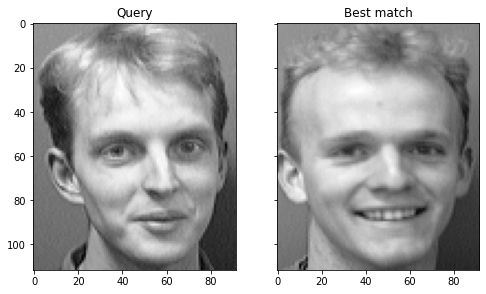

In [ ]:
## Out of Sample test
query = faces["s40/1.pgm"].reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print("Best match %s with Euclidean distance %f" % (facelabel[best_match], euclidean_distance[best_match]))
# Visualize
fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(faceshape), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(facematrix[best_match].reshape(faceshape), cmap="gray")
axes[1].set_title("Best match")
plt.show()

Showing sample faces


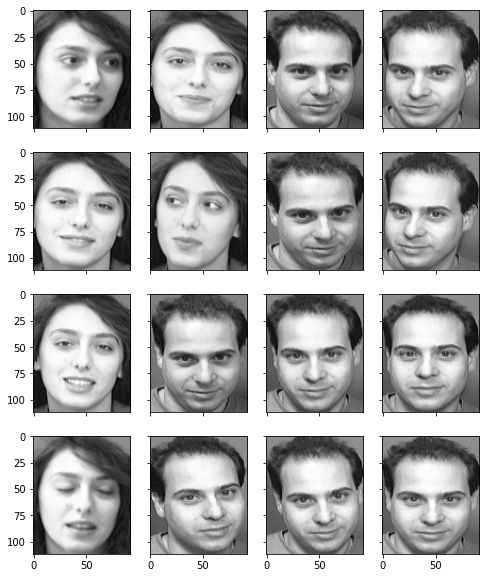

In [ ]:
## Show the last 16 original images again for comparison
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
faceimages = list(faces.values())[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

In [ ]:
## reconstruction code
# Project data to PCA and do the reconstruction

# Fit a PCA with 50 components
pcaNew = PCA(50)

# ToDo:
# Fit the model with facematrix and apply the dimensionality reduction on facematrix.
X_proj = pcaNew.fit_transform(facematrix)

# ToDo:
# Transform data back to its original space.
X_inv_proj = pcaNew.inverse_transform(X_proj)

#Setup a figure 8 inches by 8 inches
fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # plot the faces, each image is 64 by 64 dimension but 8x8 pixels for i in range(64): ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) ax.imshow(X_proj_img[i], cmap=plt.cm.bone, interpolation='nearest') - See more at: https://shankarmsy.github.io/posts/pca-sklearn.html#sthash.5rN3fqhp.dpuf

# reshape the image data into multiple dimensional array
## Very important detail here
X_proj_img = np.reshape(X_inv_proj,(X_inv_proj.shape[0],
                                    faceshape[0],faceshape[1]))

<Figure size 576x576 with 0 Axes>

Showing sample faces


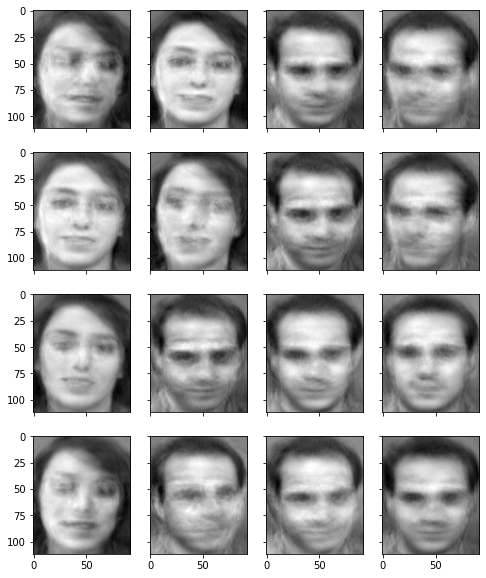

In [ ]:
## Show the last 16 reconstructed images
fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
projimages = X_proj_img[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(projimages[i], cmap="gray")
print("Showing sample faces")
plt.show()

Showing sample faces


<Figure size 576x576 with 0 Axes>

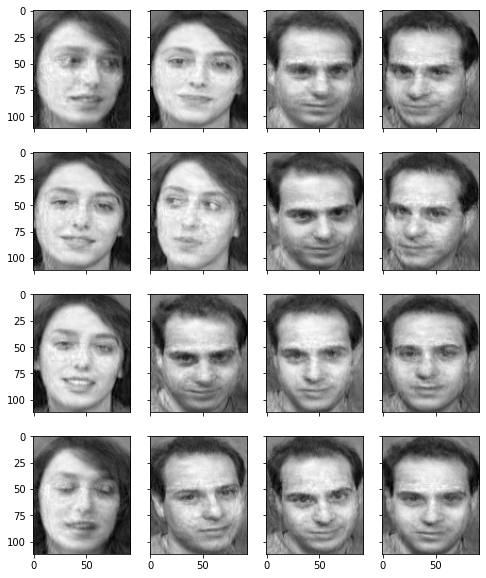

In [ ]:
## Increase the principle component number from 50 to 200
## And recheck the reconstruction quality

pcaNew = PCA(200)

X_proj = pcaNew.fit_transform(facematrix)

X_inv_proj = pcaNew.inverse_transform(X_proj)

fig = plt.figure(figsize=(8,8))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) # plot the faces, each image is 64 by 64 dimension but 8x8 pixels for i in range(64): ax = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[]) ax.imshow(X_proj_img[i], cmap=plt.cm.bone, interpolation='nearest') - See more at: https://shankarmsy.github.io/posts/pca-sklearn.html#sthash.5rN3fqhp.dpuf

X_proj_img = np.reshape(X_inv_proj,(X_inv_proj.shape[0],
                                    faceshape[0],faceshape[1]))

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
projimages = X_proj_img[-16:] # take last 16 images
for i in range(16):
    axes[i%4][i//4].imshow(projimages[i], cmap="gray")
print("Showing sample faces")
plt.show()
